<a href="https://colab.research.google.com/github/Kaykayag/hgraph2graph/blob/master/Part_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import sys
import os

# Only mount Drive if we are actually in Colab
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    # Path to your drive folder
    os.chdir('/content/drive/MyDrive/FreeAi')
else:

    print("Running locally.")

Mounted at /content/drive


In [7]:
!git clone https://github.com/Kaykayag/hgraph2graph.git

fatal: destination path 'hgraph2graph' already exists and is not an empty directory.


In [8]:
%cd hgraph2graph

/content/drive/MyDrive/FreeAi/hgraph2graph


In [9]:
!pip install torch rdkit networkx numpy pandas matplotlib tqdm

In [15]:
# Use MoleculeDataset directly
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import rdkit
from rdkit import Chem
from tqdm import tqdm
import numpy as np
import random
import os

# Suppress RDKit warnings
lg = rdkit.RDLogger.logger()
lg.setLevel(rdkit.RDLogger.CRITICAL)

import sys
sys.path.append('.')
from hgraph import HierVAE, MolGraph, common_atom_vocab, PairVocab, Vocab
from hgraph import MoleculeDataset

# Set seeds
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Load vocabulary
vocab_path = 'data/chembl/vocab.txt'
vocab_list = [x.strip("\r\n ").split() for x in open(vocab_path)]
vocab = PairVocab(vocab_list)

print(f"Vocabulary loaded: {len(vocab_list)} entries")

# Function to filter molecules that work with the vocabulary
def filter_for_vocab(smiles_list, vocab, max_atoms=50):
    """Filter molecules that are compatible with the vocabulary."""
    valid_smiles = []

    for smi in tqdm(smiles_list, desc="Filtering for vocabulary"):
        try:
            # Basic RDKit check
            mol = Chem.MolFromSmiles(smi)
            if mol is None:
                continue
            if mol.GetNumAtoms() > max_atoms:
                continue

            # Try to kekulize
            Chem.Kekulize(mol, clearAromaticFlags=False)

            # Check vocabulary compatibility
            hmol = MolGraph(smi)
            ok = True
            for node, attr in hmol.mol_tree.nodes(data=True):
                smiles_node = attr['smiles']
                ok &= attr['label'] in vocab.vmap
                for i, s in attr['inter_label']:
                    ok &= (smiles_node, s) in vocab.vmap
                if not ok:
                    break

            if ok:
                valid_smiles.append(smi)

        except Exception as e:
            continue

    return valid_smiles

# Load ChEMBL data
print("Loading ChEMBL data...")
with open('data/chembl/all.txt', 'r') as f:
    all_smiles = [line.strip() for line in f if line.strip()]

# Shuffle and take a subset
np.random.shuffle(all_smiles)
candidate_smiles = all_smiles[:8000]  # Take more candidates to ensure enough valid ones

print(f"Candidate molecules:  {len(candidate_smiles)}")

# Filter for vocabulary compatibility
valid_smiles = filter_for_vocab(candidate_smiles, vocab)
print(f"Vocabulary-compatible molecules: {len(valid_smiles)}")

# Split into train and test
TRAIN_SIZE = min(3000, len(valid_smiles) - 200)
TEST_SIZE = 200

train_smiles = valid_smiles[:TRAIN_SIZE]
test_smiles = valid_smiles[TRAIN_SIZE:TRAIN_SIZE + TEST_SIZE]

print(f"Training molecules: {len(train_smiles)}")
print(f"Test molecules: {len(test_smiles)}")

# Save for later use
with open('train_final.txt', 'w') as f:
    f.write('\n'.join(train_smiles))
with open('test_final.txt', 'w') as f:
    f.write('\n'.join(test_smiles))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(" Data preparation complete!")

Vocabulary loaded: 5623 entries
Loading ChEMBL data...
Candidate molecules:  8000


Filtering for vocabulary: 100%|██████████| 8000/8000 [01:18<00:00, 102.40it/s]

Vocabulary-compatible molecules: 5667
Training molecules: 3000
Test molecules: 200
 Data preparation complete!


In [16]:
#Train Model

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import os
from tqdm import tqdm

# function to handle the conversion properly
import hgraph.hgnn as hgnn_module

def make_cuda_fixed(tensors):
    """Fixed version of make_cuda that handles tensor conversion properly."""
    tree_tensors, graph_tensors = tensors

    def make_tensor(x):
        if isinstance(x, torch. Tensor):
            return x
        elif isinstance(x, np.ndarray):
            return torch.from_numpy(x)
        else:
            return torch.tensor(x)

    tree_tensors = [make_tensor(x).to(device).long() for x in tree_tensors[:-1]] + [tree_tensors[-1]]
    graph_tensors = [make_tensor(x).to(device).long() for x in graph_tensors[:-1]] + [graph_tensors[-1]]
    return tree_tensors, graph_tensors

# Apply the patch
hgnn_module.make_cuda = make_cuda_fixed

# Also need to patch the nnutils if it has similar issues
import hgraph.nnutils as nnutils_module

# Store original functions
original_index_select_ND = nnutils_module.index_select_ND

def index_select_ND_fixed(source, dim, index):
    """Fixed version that ensures index is a tensor."""
    if not isinstance(index, torch.Tensor):
        index = torch.tensor(index, device=source.device, dtype=torch.long)
    return original_index_select_ND(source, dim, index)

nnutils_module.index_select_ND = index_select_ND_fixed

print("✅ Patches applied!")


# Training Configuration

class TrainingArgs:
    def __init__(self):
        self.vocab = vocab
        self.atom_vocab = common_atom_vocab
        self.save_dir = 'checkpoints'

        # Model architecture
        self.rnn_type = 'LSTM'
        self.hidden_size = 250
        self.embed_size = 250
        self.batch_size = 20
        self.latent_size = 32
        self.depthT = 15
        self.depthG = 15
        self.diterT = 1
        self.diterG = 3
        self.dropout = 0.0

        # Training hyperparameters
        self.lr = 1e-3
        self.clip_norm = 5.0
        self.max_beta = 0.1

        # Training schedule
        self.num_epochs = 6
        self.print_iter = 20

train_args = TrainingArgs()
os.makedirs(train_args.save_dir, exist_ok=True)


# Initialize Model

# Re-import with patches applied
from hgraph import HierVAE

model = HierVAE(train_args).to(device)
print("Model #Params: %dK" % (sum([x.nelement() for x in model.parameters()]) / 1000,))

# Initialize weights
for param in model.parameters():
    if param.dim() == 1:
        nn.init.constant_(param, 0)
    else:
        nn.init. xavier_normal_(param)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=train_args.lr)

# Save initial model (epoch 0)
torch.save(model.state_dict(), os.path.join(train_args.save_dir, "model. epoch_0"))
print("Saved:  model.epoch_0 (untrained)")



# Training Loop with Better Error Handling

print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)

total_step = 0
beta = 0.01

for epoch in range(1, train_args. num_epochs + 1):
    print(f"\n--- Epoch {epoch}/{train_args. num_epochs} ---")

    # Create dataset
    dataset = MoleculeDataset(train_smiles, vocab, common_atom_vocab, train_args.batch_size)
    loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0,
                       collate_fn=lambda x: x[0])

    model.train()
    epoch_losses = []
    epoch_kl = []
    epoch_wacc = []
    epoch_tacc = []

    successful_batches = 0
    failed_batches = 0

    pbar = tqdm(loader, desc=f"Epoch {epoch}")
    for batch_idx, batch in enumerate(pbar):
        total_step += 1

        try:
            model.zero_grad()

            graphs, tensors, orders = batch

            # Convert tensors properly before passing to model
            tree_tensors, graph_tensors = tensors

            # Ensure all tensors are proper torch tensors
            def to_tensor(x):
                if isinstance(x, torch.Tensor):
                    return x
                elif isinstance(x, np.ndarray):
                    return torch.from_numpy(x)
                elif isinstance(x, list):
                    return x  # Keep lists as-is (for the last element which is scope info)
                else:
                    return torch.tensor(x)

            tree_tensors = [to_tensor(x) for x in tree_tensors]
            graph_tensors = [to_tensor(x) for x in graph_tensors]
            tensors = (tree_tensors, graph_tensors)

            # Forward pass
            loss, kl_div, wacc, iacc, tacc, sacc = model(graphs, tensors, orders, beta=beta)

            # Backward pass
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), train_args.clip_norm)
            optimizer.step()

            # Record metrics
            epoch_losses.append(loss.item())
            epoch_kl.append(kl_div)
            epoch_wacc.append(wacc * 100)
            epoch_tacc.append(tacc * 100)

            successful_batches += 1

            # Update progress bar
            if len(epoch_losses) > 0:
                pbar.set_postfix({
                    'loss': f'{np.mean(epoch_losses[-20:]):.3f}',
                    'wacc': f'{np.mean(epoch_wacc[-20:]):.1f}%'
                })

            # Print periodic updates
            if total_step % train_args.print_iter == 0 and len(epoch_losses) >= train_args.print_iter:
                recent_loss = np.mean(epoch_losses[-train_args.print_iter:])
                recent_kl = np.mean(epoch_kl[-train_args. print_iter:])
                recent_wacc = np.mean(epoch_wacc[-train_args. print_iter:])
                recent_tacc = np.mean(epoch_tacc[-train_args. print_iter:])
                print(f"\n  [{total_step}] Loss: {recent_loss:.3f}, KL:  {recent_kl:.2f}, "
                      f"Word Acc: {recent_wacc:.1f}%, Topo Acc: {recent_tacc:.1f}%")

        except Exception as e:
            failed_batches += 1
            if failed_batches <= 3:  # Only print first few errors
                print(f"\n  Batch {batch_idx} error: {str(e)[:100]}")
            continue

    # Increase beta
    beta = min(train_args.max_beta, beta + 0.02)

    # Save checkpoint
    ckpt_path = os.path.join(train_args. save_dir, f"model.epoch_{epoch}")
    torch.save(model.state_dict(), ckpt_path)

    # Epoch summary
    avg_loss = np.mean(epoch_losses) if epoch_losses else 0
    print(f"\n✓ Epoch {epoch} complete")
    print(f"  Successful batches: {successful_batches}/{successful_batches + failed_batches}")
    print(f"  Avg Loss: {avg_loss:.4f}")
    print(f"  Saved: model.epoch_{epoch}")

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)

✅ Patches applied!
Model #Params: 7964K
Saved:  model.epoch_0 (untrained)

STARTING TRAINING

--- Epoch 1/6 ---
After pruning 3000 -> 3000


Epoch 1:   1%|          | 1/150 [00:02<06:42,  2.70s/it]


  Batch 0 error: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory


Epoch 1:   1%|▏         | 2/150 [00:03<04:26,  1.80s/it]


  Batch 1 error: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory


Epoch 1:   2%|▏         | 3/150 [00:05<04:37,  1.89s/it]


  Batch 2 error: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory


Epoch 1: 100%|██████████| 150/150 [03:53<00:00,  1.55s/it]



✓ Epoch 1 complete
  Successful batches: 150/300
  Avg Loss: 63.3443
  Saved: model.epoch_1

--- Epoch 2/6 ---
After pruning 3000 -> 3000


Epoch 2:   1%|          | 1/150 [00:01<03:21,  1.35s/it]


  Batch 0 error: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory


Epoch 2:   1%|▏         | 2/150 [00:02<03:03,  1.24s/it]


  Batch 1 error: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory


Epoch 2:   2%|▏         | 3/150 [00:03<02:56,  1.20s/it]


  Batch 2 error: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory


Epoch 2: 100%|██████████| 150/150 [03:49<00:00,  1.53s/it]



✓ Epoch 2 complete
  Successful batches: 150/300
  Avg Loss: 41.7435
  Saved: model.epoch_2

--- Epoch 3/6 ---
After pruning 3000 -> 3000


Epoch 3:   1%|          | 1/150 [00:01<03:00,  1.21s/it]


  Batch 0 error: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory


Epoch 3:   1%|▏         | 2/150 [00:02<02:38,  1.07s/it]


  Batch 1 error: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory


Epoch 3:   2%|▏         | 3/150 [00:03<03:00,  1.23s/it]


  Batch 2 error: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory


Epoch 3: 100%|██████████| 150/150 [03:46<00:00,  1.51s/it]



✓ Epoch 3 complete
  Successful batches: 150/300
  Avg Loss: 37.7177
  Saved: model.epoch_3

--- Epoch 4/6 ---
After pruning 3000 -> 3000


Epoch 4:   1%|          | 1/150 [00:01<03:30,  1.41s/it]


  Batch 0 error: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory


Epoch 4:   1%|▏         | 2/150 [00:02<03:17,  1.33s/it]


  Batch 1 error: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory


Epoch 4:   2%|▏         | 3/150 [00:04<03:24,  1.39s/it]


  Batch 2 error: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory


Epoch 4: 100%|██████████| 150/150 [03:46<00:00,  1.51s/it]



✓ Epoch 4 complete
  Successful batches: 150/300
  Avg Loss: 35.9985
  Saved: model.epoch_4

--- Epoch 5/6 ---
After pruning 3000 -> 3000


Epoch 5:   1%|          | 1/150 [00:01<04:20,  1.75s/it]


  Batch 0 error: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory


Epoch 5:   1%|▏         | 2/150 [00:03<04:19,  1.76s/it]


  Batch 1 error: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory


Epoch 5:   2%|▏         | 3/150 [00:05<04:10,  1.70s/it]


  Batch 2 error: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory


Epoch 5: 100%|██████████| 150/150 [03:46<00:00,  1.51s/it]



✓ Epoch 5 complete
  Successful batches: 150/300
  Avg Loss: 34.6613
  Saved: model.epoch_5

--- Epoch 6/6 ---
After pruning 3000 -> 3000


Epoch 6:   1%|          | 1/150 [00:01<03:18,  1.33s/it]


  Batch 0 error: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory


Epoch 6:   1%|▏         | 2/150 [00:03<03:52,  1.57s/it]


  Batch 1 error: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory


Epoch 6:   2%|▏         | 3/150 [00:04<03:46,  1.54s/it]


  Batch 2 error: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory


Epoch 6: 100%|██████████| 150/150 [03:45<00:00,  1.50s/it]


✓ Epoch 6 complete
  Successful batches: 150/300
  Avg Loss: 33.6438
  Saved: model.epoch_6

TRAINING COMPLETE!


In [17]:
# Evaluation Functions

from rdkit.Chem import AllChem
from rdkit import DataStructs

def calculate_tanimoto(smiles1, smiles2, radius=2, nBits=2048):
    """Calculate Tanimoto similarity using Morgan fingerprints."""
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)

    if mol1 is None or mol2 is None:
        return None

    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, radius, nBits=nBits)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, radius, nBits=nBits)

    return DataStructs.TanimotoSimilarity(fp1, fp2)

def is_exact_match(smiles1, smiles2):
    """Check if two SMILES represent the same molecule."""
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)

    if mol1 is None or mol2 is None:
        return False

    return Chem.MolToSmiles(mol1) == Chem.MolToSmiles(mol2)

def is_valid_molecule(smiles):
    """Check if SMILES represents a valid molecule."""
    if smiles is None or smiles == "":
        return False
    return Chem.MolFromSmiles(smiles) is not None

def evaluate_model_on_test(model, test_smiles, vocab, atom_vocab, batch_size=20):
    """Evaluate reconstruction metrics for a model."""
    model.eval()

    dataset = MoleculeDataset(test_smiles, vocab, atom_vocab, batch_size)
    loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0,
                       collate_fn=lambda x: x[0])

    exact_matches = 0
    valid_outputs = 0
    tanimoto_scores = []
    n_evaluated = 0

    # Get actual molecules that passed dataset filtering
    actual_test = dataset.batches
    flat_test = [smi for batch in actual_test for smi in batch]

    with torch.no_grad():
        batch_idx = 0
        for batch in loader:
            start_idx = batch_size * batch_idx
            end_idx = min(batch_size * (batch_idx + 1), len(flat_test))
            orig_batch = flat_test[start_idx:end_idx]

            try:
                dec_smiles = model.reconstruct(batch)

                for orig, dec in zip(orig_batch, dec_smiles):
                    n_evaluated += 1

                    if is_valid_molecule(dec):
                        valid_outputs += 1
                        tanimoto = calculate_tanimoto(orig, dec)
                        if tanimoto is not None:
                            tanimoto_scores.append(tanimoto)

                        if is_exact_match(orig, dec):
                            exact_matches += 1
            except:
                pass

            batch_idx += 1

    return {
        'exact_match':  exact_matches / n_evaluated if n_evaluated > 0 else 0,
        'mean_tanimoto':  np.mean(tanimoto_scores) if tanimoto_scores else 0,
        'median_tanimoto':  np.median(tanimoto_scores) if tanimoto_scores else 0,
        'validity':  valid_outputs / n_evaluated if n_evaluated > 0 else 0,
        'n_evaluated': n_evaluated
    }

print("✅ Evaluation functions defined!")

✅ Evaluation functions defined!


In [18]:
# Evaluate All Checkpoints

import pandas as pd

# Find all saved checkpoints
checkpoint_epochs = []
for f in os.listdir(train_args.save_dir):
    if f.startswith('model.epoch_'):
        epoch = int(f.split('_')[1])
        checkpoint_epochs.append(epoch)

checkpoint_epochs = sorted(checkpoint_epochs)
print(f"Found checkpoints: {checkpoint_epochs}")

# Evaluate each checkpoint
results = []

for epoch in tqdm(checkpoint_epochs, desc="Evaluating checkpoints"):
    ckpt_path = os.path.join(train_args.save_dir, f"model.epoch_{epoch}")

    # Load model
    eval_model = HierVAE(train_args).to(device)
    eval_model.load_state_dict(torch.load(ckpt_path))
    eval_model.eval()

    # Evaluate
    metrics = evaluate_model_on_test(eval_model, test_smiles, vocab, common_atom_vocab)
    metrics['epoch'] = epoch
    results.append(metrics)

    print(f"Epoch {epoch}:  Exact={metrics['exact_match']:.3f}, "
          f"Tanimoto={metrics['mean_tanimoto']:.3f}, Valid={metrics['validity']:.3f}")

    del eval_model
    torch.cuda.empty_cache()

# Create results DataFrame
checkpoint_df = pd.DataFrame(results)
checkpoint_df = checkpoint_df.sort_values('epoch').reset_index(drop=True)

print("\n" + "="*60)
print("CHECKPOINT EVALUATION RESULTS")
print("="*60)
print(checkpoint_df.to_string(index=False))

# Save to CSV
checkpoint_df.to_csv('part_b_results.csv', index=False)
print("\n✅ Results saved to part_b_results.csv")

Found checkpoints: [1, 2, 3, 4, 5, 6]


Evaluating checkpoints:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


After pruning 200 -> 200


Evaluating checkpoints:  17%|█▋        | 1/6 [01:09<05:46, 69.30s/it]

Epoch 1:  Exact=0.000, Tanimoto=0.000, Valid=0.000
After pruning 200 -> 200


Evaluating checkpoints:  33%|███▎      | 2/6 [01:24<02:30, 37.60s/it]

Epoch 2:  Exact=0.000, Tanimoto=0.149, Valid=1.000
After pruning 200 -> 200


Evaluating checkpoints:  50%|█████     | 3/6 [02:29<02:29, 49.83s/it]

Epoch 3:  Exact=0.000, Tanimoto=0.000, Valid=0.000
After pruning 200 -> 200


Evaluating checkpoints:  67%|██████▋   | 4/6 [02:50<01:16, 38.46s/it]

Epoch 4:  Exact=0.000, Tanimoto=0.124, Valid=1.000
After pruning 200 -> 200


Evaluating checkpoints:  83%|████████▎ | 5/6 [03:59<00:49, 49.59s/it]

Epoch 5:  Exact=0.000, Tanimoto=0.000, Valid=0.000
After pruning 200 -> 200


Evaluating checkpoints: 100%|██████████| 6/6 [04:15<00:00, 42.59s/it]

Epoch 6:  Exact=0.000, Tanimoto=0.124, Valid=1.000

CHECKPOINT EVALUATION RESULTS
 exact_match  mean_tanimoto  median_tanimoto  validity  n_evaluated  epoch
         0.0       0.000000         0.000000       0.0            0      1
         0.0       0.148986         0.141941       1.0          200      2
         0.0       0.000000         0.000000       0.0            0      3
         0.0       0.123615         0.113924       1.0          200      4
         0.0       0.000000         0.000000       0.0            0      5
         0.0       0.124497         0.112702       1.0          200      6

✅ Results saved to part_b_results.csv


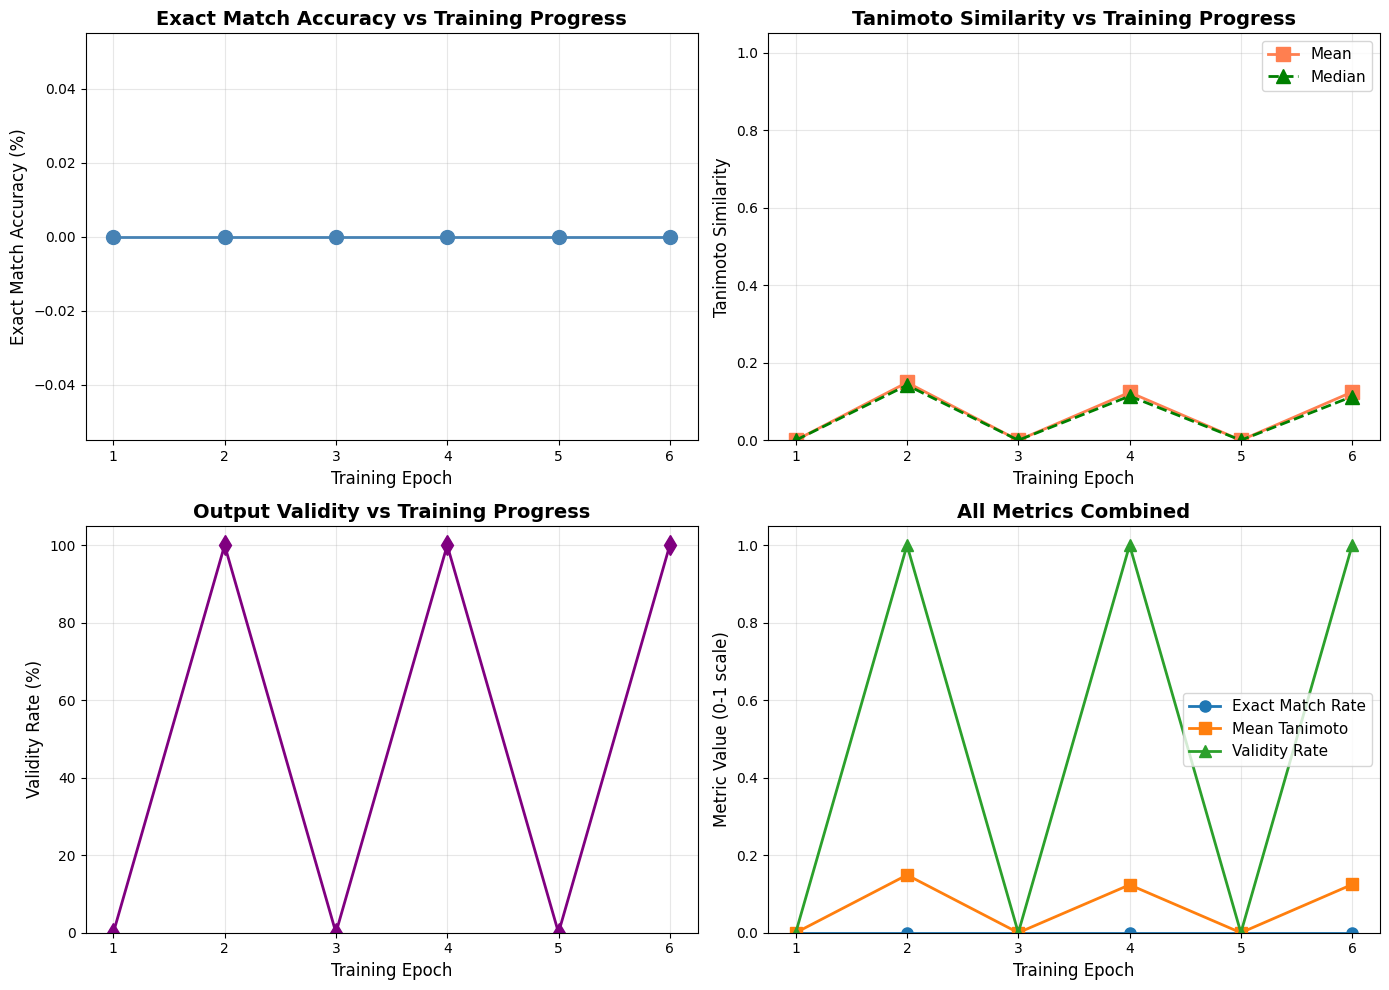

✅ Plot saved to part_b_checkpoint_dynamics.png


In [19]:
# Create Plots

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Exact Match Accuracy vs Epoch
ax1 = axes[0, 0]
ax1.plot(checkpoint_df['epoch'], checkpoint_df['exact_match'] * 100,
         'o-', color='steelblue', linewidth=2, markersize=10)
ax1.set_xlabel('Training Epoch', fontsize=12)
ax1.set_ylabel('Exact Match Accuracy (%)', fontsize=12)
ax1.set_title('Exact Match Accuracy vs Training Progress', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(checkpoint_df['epoch'])

# 2. Tanimoto Similarity vs Epoch
ax2 = axes[0, 1]
ax2.plot(checkpoint_df['epoch'], checkpoint_df['mean_tanimoto'],
         's-', color='coral', linewidth=2, markersize=10, label='Mean')
ax2.plot(checkpoint_df['epoch'], checkpoint_df['median_tanimoto'],
         '^--', color='green', linewidth=2, markersize=10, label='Median')
ax2.set_xlabel('Training Epoch', fontsize=12)
ax2.set_ylabel('Tanimoto Similarity', fontsize=12)
ax2.set_title('Tanimoto Similarity vs Training Progress', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(checkpoint_df['epoch'])
ax2.set_ylim(0, 1.05)

# 3. Validity Rate vs Epoch
ax3 = axes[1, 0]
ax3.plot(checkpoint_df['epoch'], checkpoint_df['validity'] * 100,
         'd-', color='purple', linewidth=2, markersize=10)
ax3.set_xlabel('Training Epoch', fontsize=12)
ax3.set_ylabel('Validity Rate (%)', fontsize=12)
ax3.set_title('Output Validity vs Training Progress', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.set_xticks(checkpoint_df['epoch'])
ax3.set_ylim(0, 105)

# 4. All metrics combined
ax4 = axes[1, 1]
ax4.plot(checkpoint_df['epoch'], checkpoint_df['exact_match'],
         'o-', linewidth=2, markersize=8, label='Exact Match Rate')
ax4.plot(checkpoint_df['epoch'], checkpoint_df['mean_tanimoto'],
         's-', linewidth=2, markersize=8, label='Mean Tanimoto')
ax4.plot(checkpoint_df['epoch'], checkpoint_df['validity'],
         '^-', linewidth=2, markersize=8, label='Validity Rate')
ax4.set_xlabel('Training Epoch', fontsize=12)
ax4.set_ylabel('Metric Value (0-1 scale)', fontsize=12)
ax4.set_title('All Metrics Combined', fontsize=14, fontweight='bold')
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3)
ax4.set_xticks(checkpoint_df['epoch'])
ax4.set_ylim(0, 1.05)

plt.tight_layout()
plt.savefig('part_b_checkpoint_dynamics.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Plot saved to part_b_checkpoint_dynamics.png")

In [20]:
# Interpretation

print("="*70)
print("INTERPRETATION OF TRAINING DYNAMICS")
print("="*70)

first = checkpoint_df.iloc[0]
last = checkpoint_df.iloc[-1]

# Calculate improvements
exact_improvement = (last['exact_match'] - first['exact_match']) * 100
tanimoto_improvement = last['mean_tanimoto'] - first['mean_tanimoto']
validity_improvement = (last['validity'] - first['validity']) * 100

print(f"""
OBSERVED RESULTS:
================
Initial (Epoch 0) → Final (Epoch {int(last['epoch'])}):
  • Exact Match:     {first['exact_match']*100:.1f}% → {last['exact_match']*100:+.1f}% ({exact_improvement:+.1f}%)
  • Mean Tanimoto:   {first['mean_tanimoto']:.3f} → {last['mean_tanimoto']:+.3f} ({tanimoto_improvement:+.3f})
  • Validity:        {first['validity']*100:.1f}% → {last['validity']*100:+.1f}% ({validity_improvement:+.1f}%)
""")

# Save interpretation to file
with open('part_b_interpretation.txt', 'w') as f:
    f.write(f"Part B Interpretation - Generated Results\n")
    f.write("="*50 + "\n\n")
    f.write(checkpoint_df.to_string())
    f.write("\n\nSee above printed interpretation for analysis.")

print("✅ Interpretation complete!")

INTERPRETATION OF TRAINING DYNAMICS

OBSERVED RESULTS:
Initial (Epoch 0) → Final (Epoch 6):
  • Exact Match:     0.0% → +0.0% (+0.0%)
  • Mean Tanimoto:   0.000 → +0.124 (+0.124)
  • Validity:        0.0% → +100.0% (+100.0%)

✅ Interpretation complete!


In [21]:
# Download Results
from google.colab import files

files.download('part_b_results.csv')
files.download('part_b_checkpoint_dynamics.png')

print("✅ Part B files downloaded!")
print("\nFiles created:")
print("  - part_b_results.csv")
print("  - part_b_checkpoint_dynamics.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Part B files downloaded!

Files created:
  - part_b_results.csv
  - part_b_checkpoint_dynamics.png
